In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request


print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [276]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [277]:
data.sample(10)

,headlines,text
29545,Heat wave to continue in Delhi-NCR till May 27...,The India Meteorological Department (IMD) scie...
94228,First UK-China freight train departs on Monday,The first rail freight service from UK to Chin...
11639,Doordarshan cameraman's family to get Ã¢ÂÂ¹15...,Information and Broadcasting Minister Rajyavar...
82995,"Patna Police officers play games, browse net d...",Two Patna Police officers were caught playing ...
26708,Jeremy Hunt appointed new UK Foreign Secretary,British Prime Minister Theresa May on Monday a...
30234,Rishi tweets royal wedding video dubbed using ...,Rishi Kapoor tweeted a video of Prince Harry a...
19852,SC judges sing to raise funds for Kerala flood...,Supreme Court judges Kurian Joseph and KM Jose...
27861,'Sanju' records highest day 2 earnings in Boll...,With earnings of Ã¢ÂÂ¹38.60 crore on the seco...
20798,"Asiad champs Bajrang, Vinesh to get Ã¢ÂÂ¹3 cr...","Wrestler Vinesh Phogat, who became the first I..."
39067,IBC amendments to eliminate 'fly by night' rea...,Finance Minister Arun Jaitley has said the ame...


In [278]:
print('전체 샘플수 :', (len(data)))
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401
전체 샘플수 : 98360
전체 샘플수 : 98360


In [279]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [280]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []
for txt in data['text']:
    clean_text.append(preprocess_sentence(txt))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_headlines = []
for head in data['headlines']:
    clean_headlines.append(preprocess_sentence(head, False))

print("Headline 전처리 후 결과: ", clean_headlines[:5])

Headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [281]:
data['clean_text'] = clean_text
data['clean_headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [282]:
print(len(data))

98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
제목의 최소 길이 : 1
제목의 최대 길이 : 16
제목의 평균 길이 : 9.299532330215534


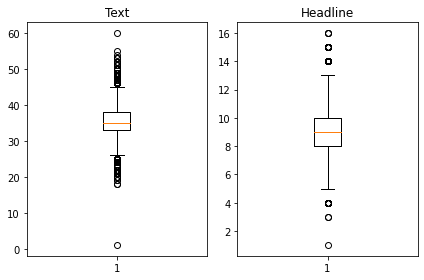

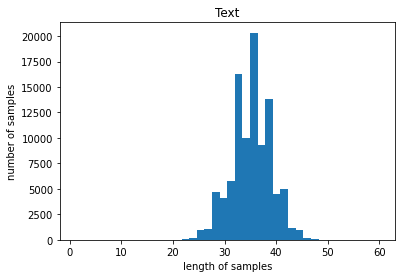

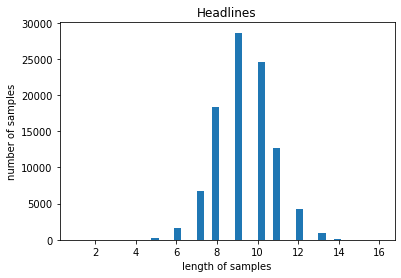

In [283]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['clean_text']]
headline_len = [len(s.split()) for s in data['clean_headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(headline_len)))
print('제목의 최대 길이 : {}'.format(np.max(headline_len)))
print('제목의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('Headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [284]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 개수: %s'%(max_len,cnt))
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [285]:
text_max_len = 44
headline_max_len = 13

below_threshold_len(text_max_len, data['clean_text'])
below_threshold_len(headline_max_len,  data['clean_headlines'])

전체 샘플 중 길이가 44 이하인 샘플의 개수: 97708
전체 샘플 중 길이가 44 이하인 샘플의 비율: 0.9933712891419276
전체 샘플 중 길이가 13 이하인 샘플의 개수: 98180
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [286]:
data = data[data['clean_text'].apply(lambda x:len(x.split())<=text_max_len) & data['clean_headlines'].apply(lambda x:len(x.split())<=headline_max_len)]

print('전체 샘플수 :', (len(data)))
print(data.iloc[0])

전체 샘플수 : 97528
headlines          upGrad learner switches to career in ML & Al w...
text               Saurav Kant, an alumnus of upGrad and IIIT-B's...
clean_text         saurav kant alumnus upgrad iiit pg program mac...
clean_headlines    upgrad learner switches to career in ml al wit...
Name: 0, dtype: object


In [287]:
data['decoder_input'] = data['clean_headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['clean_headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,clean_text,clean_headlines,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [288]:
encoder_input = np.array(data['clean_text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [289]:
# random index list
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[63849  7401 61973 ... 45569 58485 67253]


In [290]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [291]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19505


In [292]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78023
훈련 레이블의 개수 : 78023
테스트 데이터의 개수 : 19505
테스트 레이블의 개수 : 19505


In [293]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [294]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69064
등장 빈도가 6번 이하인 희귀 단어의 수: 47044
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22020
단어 집합에서 희귀 단어의 비율: 68.11652959573729
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4989527215519844


In [295]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [296]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[135, 14, 2465, 48, 63, 1, 2, 20577, 2504, 7322, 104, 22, 197, 356, 581, 3296, 4684, 16602, 550, 3796, 104, 299, 327, 31, 42, 8675, 8, 1754, 912, 1, 1754, 83, 119, 2, 14175], [630, 449, 4583, 617, 299, 915, 98, 5067, 177, 105, 684, 99, 3842, 4516, 13287, 15875, 233, 299, 3247, 366, 9115, 671, 487, 447, 1, 551, 23, 1328, 16603, 18295, 603], [2164, 532, 1277, 12509, 9116, 2505, 750, 12134, 13288, 5446, 8243, 1410, 1032, 75, 5900, 12135, 26, 14664, 12887, 1479, 903, 9621, 7761, 768, 1586, 5020, 7997, 12136, 1626, 2842, 12134, 560, 67, 12509, 12134, 560, 85, 1]]


In [297]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [298]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29961
등장 빈도가 4번 이하인 희귀 단어의 수: 18459
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11502
단어 집합에서 희귀 단어의 비율: 61.610093121057375
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9638106886506104


In [299]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 8, 64, 5, 92, 1099, 216], [1, 3672, 200, 5631, 4, 550, 271, 3, 1100, 680, 4220], [1, 6151, 70, 6462, 2909, 10417, 8144, 5407], [1, 46, 31, 1101, 1346, 3, 2090, 53, 6, 384, 1216, 2245, 268], [1, 716, 396, 3, 165, 5, 4353, 30, 5632]]
target
decoder  [[8, 64, 5, 92, 1099, 216, 2], [3672, 200, 5631, 4, 550, 271, 3, 1100, 680, 4220, 2], [6151, 70, 6462, 2909, 10417, 8144, 5407, 2], [46, 31, 1101, 1346, 3, 2090, 53, 6, 384, 1216, 2245, 268, 2], [716, 396, 3, 165, 5, 4353, 30, 5632, 2]]


In [300]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78023
훈련 레이블의 개수 : 78023
테스트 데이터의 개수 : 19505
테스트 레이블의 개수 : 19505


In [301]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='pre')

In [302]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

'''class Encoder:
    def __init__(self, src_vocab, embedding_dim=128, hidden_size=256, text_max_len=None):
        # 인코더 설계 시작
        self.src_vocab = src_vocab
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.text_max_len = text_max_len

    def build(self):
        encoder_inputs = Input(shape=(self.text_max_len,))
        # 인코더의 임베딩 층
        enc_emb = Embedding(self.src_vocab, self.embedding_dim)(encoder_inputs)

        encoder_lstm1 = LSTM(self.hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
        encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
        #encoder_lstm2 = LSTM(self.hidden_size, return_sequences=True, return_state=True ,dropout = 0.2)
        #encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1, initial_state=[state_h1, state_c1])
        #encoder_lstm3 = LSTM(self.hidden_size, return_sequences=True, return_state=True ,dropout = 0.2)
        #encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2, initial_state=[state_h2, state_c2])

        return encoder_inputs1, encoder_outputs1, state_h, state_c1

class Decoder:
    def __init__(self, tar_vocab, embedding_dim=128, hidden_size=256):
        self.tar_vocab = tar_vocab
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.dec_emb_layer = Embedding(self.tar_vocab, self.embedding_dim, mask_zero=True)
        self.decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2)
        
    def build(self, state_h, state_c):
        # 디코더 설계
        decoder_inputs = Input(shape=(None,))
        # 디코더의 임베딩 층
        dec_emb = self.dec_emb_layer(decoder_inputs)

        # 디코더의 LSTM
        decoder_outputs, _, _ = self.decoder_lstm(dec_emb, initial_state=[state_h, state_c])

        """     # 디코더의 출력층
        decoder_softmax_layer = Dense(self.tar_vocab, activation='softmax')
        decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)"""
        
        return decoder_inputs, decoder_outputs
    
        """    def emd_layer(self):
        return self.dec_emb_layer
        def lstm(self):
        return self.decoder_lstm"""'''

class Seq2SeqModel:
    def __init__(self, src_vocab, tar_vocab, text_max_len, headline_max_len, embedding_dim=128, hidden_size=256):
        self.src_vocab = src_vocab
        self.tar_vocab = tar_vocab
        self.text_max_len = text_max_len
        self.summary_max_len = summary_max_len
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        self.model = None
        self.encoder_model = None
        self.decoder_model = None
        
         # 학습용 층
        self.encoder_inputs = Input(shape=(self.text_max_len,))
        self.enc_emb = Embedding(self.src_vocab, self.embedding_dim, mask_zero=True)(self.encoder_inputs)
        self.encoder_lstm = LSTM(self.hidden_size, return_sequences=True, return_state=True, dropout=0.2)
        self.encoder_outputs, self.state_h, self.state_c = self.encoder_lstm(self.enc_emb)

        self.decoder_inputs = Input(shape=(None,))
        self.dec_emb_layer = Embedding(self.tar_vocab, self.embedding_dim, mask_zero=True)
        self.dec_emb = self.dec_emb_layer(self.decoder_inputs)
        self.decoder_lstm = LSTM(self.hidden_size, return_sequences=True, return_state=True, dropout=0.2)
        self.decoder_outputs, _, _ = self.decoder_lstm(self.dec_emb, initial_state=[self.state_h, self.state_c])

        self.attn_layer = AdditiveAttention()
        self.attn_out = self.attn_layer([self.decoder_outputs, self.encoder_outputs])
        self.decoder_concat = Concatenate(axis=-1)([self.decoder_outputs, self.attn_out])

        self.decoder_softmax_layer = Dense(self.tar_vocab, activation='softmax')
        self.decoder_outputs_final = self.decoder_softmax_layer(self.decoder_concat)

        self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs_final)
    
    def train(self, train_data, val_data, epochs=10, batch_size=256):
        self.model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
        es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
        history = self.model.fit(
            x=[train_data[0], train_data[1]],
            y=train_data[2],
            validation_data=([val_data[0], val_data[1]], val_data[2]),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[es]
        )
        return history
    
    def build_inference(self):
        # 인코더 모델
        self.encoder_model = Model(self.encoder_inputs, [self.encoder_outputs, self.state_h, self.state_c])
        
        # 디코더 입력들
        decoder_state_input_h = Input(shape=(self.hidden_size,))
        decoder_state_input_c = Input(shape=(self.hidden_size,))
        decoder_hidden_state_input = Input(shape=(self.text_max_len, self.hidden_size))

        dec_inputs = Input(shape=(None,))
        dec_emb_inf = self.dec_emb_layer(dec_inputs)

        decoder_outputs2, state_h2, state_c2 = self.decoder_lstm(dec_emb_inf, initial_state=[decoder_state_input_h, decoder_state_input_c])
        attn_out_inf = self.attn_layer([decoder_outputs2, decoder_hidden_state_input])
        decoder_inf_concat = Concatenate(axis=-1)([decoder_outputs2, attn_out_inf])
        decoder_outputs2 = self.decoder_softmax_layer(decoder_inf_concat)

        self.decoder_model = Model(
            [dec_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
            [decoder_outputs2, state_h2, state_c2]
        )
    
    def decode_sequence(self, input_seq, tar_word_to_index, tar_index_to_word):
        e_out, e_h, e_c = self.encoder_model.predict(input_seq)

        # 시작 토큰 초기화
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = tar_word_to_index['sostoken']

        decoded_sentence = ''
        stop_condition = False

        while not stop_condition:
            output_tokens, h, c = self.decoder_model.predict([target_seq, e_out, e_h, e_c])
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = tar_index_to_word[sampled_token_index]

            if sampled_token != 'eostoken':
                decoded_sentence += ' ' + sampled_token

            if (sampled_token == 'eostoken') or (len(decoded_sentence.split()) >= self.summary_max_len - 1):
                stop_condition = True

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            e_h, e_c = h, c

        return decoded_sentence

In [303]:
seq2seq = Seq2SeqModel(src_vocab, tar_vocab, text_max_len, headline_max_len)
seq2seq.build_inference()

In [304]:
history = seq2seq.train(train_data=[encoder_input_train, decoder_input_train, decoder_target_train], 
              val_data=[encoder_input_test, decoder_input_test, decoder_target_test],
                       epochs=50)

Epoch 1/50
305/305 [==============================] - 69s 205ms/step - loss: 5.2396 - val_loss: 4.9128
Epoch 2/50
305/305 [==============================] - 60s 196ms/step - loss: 4.7233 - val_loss: 4.4479
Epoch 3/50
305/305 [==============================] - 59s 194ms/step - loss: 4.3296 - val_loss: 4.1791
Epoch 4/50
305/305 [==============================] - 59s 193ms/step - loss: 4.0724 - val_loss: 4.0188
Epoch 5/50
305/305 [==============================] - 59s 193ms/step - loss: 3.8828 - val_loss: 3.9100
Epoch 6/50
305/305 [==============================] - 59s 193ms/step - loss: 3.7274 - val_loss: 3.8145
Epoch 7/50
305/305 [==============================] - 58s 191ms/step - loss: 3.5866 - val_loss: 3.7350
Epoch 8/50
305/305 [==============================] - 62s 202ms/step - loss: 3.4600 - val_loss: 3.6733
Epoch 9/50
305/305 [==============================] - 59s 194ms/step - loss: 3.3447 - val_loss: 3.6159
Epoch 10/50
305/305 [==============================] - 59s 192ms/step - l

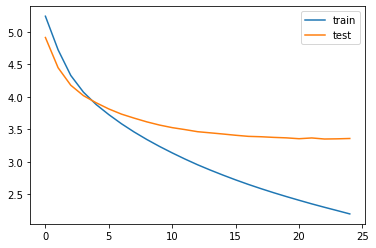

In [305]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [306]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [307]:
print(len(src_index_to_word))
print(len(tar_word_to_index))
print(len(tar_index_to_word))

print("sostoken index:", tar_word_to_index['sostoken'])
print("eostoken index:", tar_word_to_index['eostoken'])

69064
29962
29962
sostoken index: 1
eostoken index: 2


In [308]:
seq2seq.build_inference()

In [309]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    return ' '.join([tar_index_to_word.get(i, '<unk>') for i in input_seq[1:]])

In [327]:
from summa.summarizer import summarize

raw_text = np.array(data['text']) # 인코더의 입력
raw_text = raw_text[indices]
raw_text_test = raw_text[-n_of_val:]

for i in range(50, 60):
    print("원문 :", raw_text_test[i])
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", seq2seq.decode_sequence(encoder_input_test[i].reshape(1, text_max_len),
                                             tar_word_to_index,
                                             tar_index_to_word))
    print("추출 요약 :", summarize(raw_text_test[i], ratio=0.7, split=False, words=20))
    print("\n")

원문 : Pakistan on Thursday welcomed PM Narendra Modi's phone call congratulating Pakistan Tehreek-e-Insaf chief Imran Khan and said it wants to resume bilateral talks with India which were halted in 2015. PM Modi had hoped "Pakistan and India will work to open a new chapter in bilateral ties" during the call. Khan had emphasised that disputes should be resolved through dialogue.
실제 요약 : <unk> sostoken pakistan says it wants to resume bilateral talks with india
예측 요약 :  pak pm imran khan wants pm imran khan to pak pm imran
추출 요약 : Pakistan on Thursday welcomed PM Narendra Modi's phone call congratulating Pakistan Tehreek-e-Insaf chief Imran Khan and said it wants to resume bilateral talks with India which were halted in 2015.


원문 : Indian cricket captain Virat Kohli on Monday took to Twitter to wish the Indian Under-17 team for the FIFA Under-17 World Cup starting October 6. "I would like to wish them all the very best for the first game and the rest of the tournament. Go get it boys, m